In [58]:
import math
import matplotlib.pyplot as plt
%matplotlib inline

from pathlib import Path
Home = str(Path.home())

import numpy as np
import pandas as pd

import re

import sys
path = f'{Home}/repos/EPObjects/'
sys.path.insert(0, path)

from Probabilistic.Parameter import ProbabilisticParameters
from Probabilistic.EnergyPredictions import EnergyPrediction, ProbabilisticEnergyPrediction

from Helper.MLHelper import GetGenerator, GetRegressor, GetScalingLayer, Rescaling
from Helper.RunPeriodHelper import GetRunPeriodsFromFile

In [59]:
ColorsSolid = ['#1f77b4', '#d62728', '#9467bd', '#2ca02c', '#ff7f0e',]
NumColors = len(ColorsSolid)

def RGBToHex(c):
    c = c.astype(np.int16)
    return '#%02x%02x%02x' %(c[0], c[1], c[2])

def HexToRGB(h):
    return np.array([int(h[i:i+2], base=16) for i in (1, 3, 5)], dtype=np.int16)

def GetWeighedColor(col1, col2='#ffffff', w=0.5):
    c1 = HexToRGB(col1)
    c2 = HexToRGB(col2)
    return RGBToHex((c1 * (1-w)) + (w * c2))

class ColorScale:
    def __init__(self, c1, c2, mi, ma):
        self.Color1 = c1
        self.Color2 = c2
        self.Min = mi
        self.Max = ma
        self.Range = self.Max - self.Min
        
    def Color(self, value):
        if isinstance(value, np.ndarray):     
            vs = []
            for v in value:
                vs.append(GetWeighedColor(self.Color1, self.Color2, (v-self.Min)/self.Range))
            return vs
        return GetWeighedColor(self.Color1, self.Color2, (value-self.Min)/self.Range)

In [60]:
TestPath = f'{Home}/repos/EPObjects/Tausendpfund/'
pps = ProbabilisticParameters.ReadCsv(f'{TestPath}/Parameters.csv')
_, Targets = GetRunPeriodsFromFile(f'{TestPath}/Consumption.csv')

In [61]:
pEnergies = []
for i in range(10):
    data = pd.read_csv(f'{TestPath}/IDFFiles-1/{i}.csv', index_col=0)
    data.index = range(len(data))
    pEnergies += [EnergyPrediction(None, data)]

SimulationData = ProbabilisticEnergyPrediction(None, pEnergies)
Results = SimulationData.Values['Total']

In [62]:
g = GetGenerator(None, 1000, list(str(x.Parameter) for x in pps), f'{TestPath}/MLModel-1/Generator', f'{path}/MLModel-1/Regressor.h5', None, None, training=False)
Combinations = g.Predict(1, numModels=50, mean=False)

r = GetRegressor(None, list(str(x.Parameter) for x in pps), SimulationData.Values['Total'].columns, f'{TestPath}/MLModel-1/Regressor', None, None, training=False)
_ = r.Predict(Combinations)

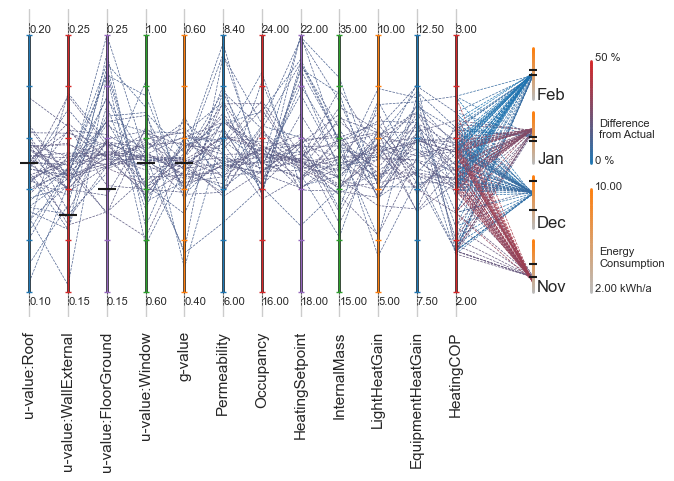

In [63]:
mi = np.array([pp.Min for pp in pps])
ra = np.array([pp.Max-pp.Min for pp in pps])
ScalingX = Rescaling(1./ra, offset = -mi/ra)
SampleScaled = ScalingX([0.15, 0.18, 0.19, 0.8, 0.5, float('nan'), float('nan'), float('nan'), float('nan'), float('nan'), float('nan'), float('nan')]).numpy()

NumParameters = len(mi)
ResultsStartAt = NumParameters + 1

fig, ax = plt.subplots(figsize=(NumParameters/2 + 2, 4), nrows = 1, ncols = 1)

for i, pp in enumerate(pps):
    ax.plot([i, i], [-.05, 1.05], lw=0.5, ls='--', color='k', zorder=1)
    ax.bar([i, i], [0, 1], width=0.05, ec='k', lw=0.5, zorder=2, color=ColorsSolid[i%NumColors])
    plt.plot(i * np.ones((6)), np.linspace(0, 1, 6), marker='_', markersize=5, color=ColorsSolid[i%NumColors], lw=0.1)
    
    plt.text(i, -0.05, f'{pp.Min:.02f}', size=8)
    plt.text(i, 1.01, f'{pp.Max:.02f}', size=8)
    
    try: plt.scatter(i, SampleScaled[i], 150, marker='_', color='k', zorder=100)
    except: pass

ma, mi = math.ceil(Results.values.max()) + 1, math.floor(Results.values.min())
ra = ma-mi
ScalingY = Rescaling(1./ra, offset = -mi/ra)

ErrorScale = ColorScale('#1f77b4', '#d62728', 0, 0.5)

previous = None
for i, comb in Combinations.iterrows():
    x = ScalingX(comb[:NumParameters]).numpy()
    for p, x1 in enumerate(x):
        if previous is not None:
            error = np.mean(np.abs((comb[NumParameters:].values - Targets.values.T.mean(axis=0))/Targets.values.T.mean(axis=0)))
            plt.plot([previous[0], p], [previous[1], x1], lw=0.5, ls='--', color=ErrorScale.Color(error), zorder=-1)
        previous = [p, x1]
    
    res = ScalingY(comb[NumParameters:]).numpy()*0.2
    for j, t in enumerate(res):
        error = np.abs((comb[NumParameters:].values[j] - Targets.values.T.mean(axis=0)[j])/Targets.values.T.mean(axis=0)[j])
        plt.plot([previous[0], ResultsStartAt], [previous[1], j*0.25 + t], lw=0.5, ls='--', color=ErrorScale.Color(error), zorder=-1)
        
    previous = None

ConsumptionScale = ColorScale('#bbbbbb', '#ff7f0e', 0, 1.0)
breaks = 50
for i, t in enumerate(Targets.values.T[0]):
    plt.text(ResultsStartAt+0.1, i*.25, Targets.index[i][:3], horizontalalignment='left')
    for j in range(breaks):
        ax.plot([ResultsStartAt, ResultsStartAt], [i*0.25 + j*0.2/breaks, i*0.25 + (j+1) * 0.2/breaks], lw=2, ls='-', color=ConsumptionScale.Color(j/breaks), zorder=1)
        if i==0:
            ax.plot([ResultsStartAt+1.5, ResultsStartAt+1.5], [i*0.25 + j*0.4/breaks, i*0.25 + (j+1) * 0.4/breaks], lw=2, ls='-', color=ConsumptionScale.Color(j/breaks), zorder=1)
    
ax.text(ResultsStartAt+1.6, 0, f'{mi:.02f} kWh/a', size=8)
ax.text(ResultsStartAt+1.7, 0.1, f'Energy\nConsumption', size=8)
ax.text(ResultsStartAt+1.6, 0.4, f'{ma:.02f}', size=8)

for j in range(breaks):
    ax.plot([ResultsStartAt+1.5, ResultsStartAt+1.5], [0.5 + j*0.4/breaks, 0.5 + (j+1) * 0.4/breaks], lw=2, ls='-', color=ErrorScale.Color(j*0.5/breaks), zorder=1)

ax.text(ResultsStartAt+1.6, 0.5, f'0 %', size=8)
ax.text(ResultsStartAt+1.7, 0.6, f'Difference\nfrom Actual', size=8)
ax.text(ResultsStartAt+1.6, 0.9, f'50 %', size=8)
        
for t in Targets.values.T:
    res = ScalingY(t).numpy() * 0.2
    for i, t in enumerate(res):
        ax.scatter([ResultsStartAt], [i*0.25 + t], marker='_', color='k')
        

# plt.axis('off')

xticks = tuple(x for x in pps)
ax.set_xticks(range(len(xticks)), labels=[str(x).split(':')[0] if 'u-' not in str(x) else str(x) for x in xticks ], rotation=90)
ax.set_yticks([])
ax.set_ylim([-0.1, 1.1])
ax.set_xlim([-.5, ResultsStartAt+2.5])

ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)

plt.savefig('test.pdf', bbox_inches='tight')

In [64]:
pEnergies = []
for i in range(10):
    data = pd.read_csv(f'{TestPath}/IDFFiles-1/{i}.csv', index_col=0)
    data = data[[c for c in data.columns if 'Energy' in c]]
    pEnergies += [EnergyPrediction(None, data)]

d = ProbabilisticEnergyPrediction(None, pEnergies)
results = d.Values['Total']

Targets.mean(axis=1), results.mean(axis=0).sum()

(Name
 November    5.3220
 December    6.9720
 January     5.7950
 February    6.1235
 dtype: float64,
 24.54692073219688)

In [65]:
pps = ProbabilisticParameters.ReadCsv(f'{TestPath}/Parameters.csv')

In [66]:
print ([p for p in pps])

[u-value:Roof, u-value:WallExternal, u-value:FloorGround, u-value:Window, g-value:Window, Permeability, Occupancy:Office, HeatingSetpoint:Office|Corridor|Stairs, InternalMass:Office, LightHeatGain:Office, EquipmentHeatGain:Office, HeatingCOP]


In [67]:
pps.GenerateSamplesAsDF(10)

,u-value:Roof,u-value:WallExternal,u-value:FloorGround,u-value:Window,g-value:Window,Permeability,Occupancy:Office,HeatingSetpoint:Office|Corridor|Stairs,InternalMass:Office,LightHeatGain:Office,EquipmentHeatGain:Office,HeatingCOP
0,0.13477,0.18544,0.18764,0.89278,0.42530,6.44100,17.36036,21.80037,25.27713,7.56285,11.93256,2.13841
1,0.12624,0.22506,0.23827,0.97256,0.52563,6.71159,19.70234,21.54426,18.26493,8.03152,11.31889,2.84515
2,0.14460,0.21207,0.19114,0.67006,0.51459,7.81935,21.74197,20.04122,21.75384,5.11580,12.26910,2.45280
3,0.10678,0.24531,0.16730,0.72257,0.41195,7.12548,22.91529,21.05406,16.52173,6.53279,10.83129,2.59048
4,0.18591,0.20141,0.22205,0.61827,0.57555,8.34985,23.23846,18.34322,33.88053,8.54089,10.21057,2.95477
5,0.19203,0.15953,0.17978,0.87409,0.44882,6.92060,16.43908,18.67393,30.56082,9.48052,8.56540,2.36278
6,0.11513,0.17995,0.21500,0.77846,0.59893,7.25056,20.08902,19.78066,31.04203,6.33026,8.44435,2.70568
7,0.15951,0.23535,0.24583,0.94762,0.49714,6.17955,19.18273,18.80832,23.36987,5.97696,9.48207,2.67975
8,0.17854,0.16595,0.20960,0.81168,0.46183,7.98387,17.63482,20.41880,27.86548,9.66970,7.92886,2.29616
9,0.16985,0.19072,0.15842,0.71146,0.54007,7.44738,21.30260,19.20776,19.72883,7.26214,9.68777,2.04130


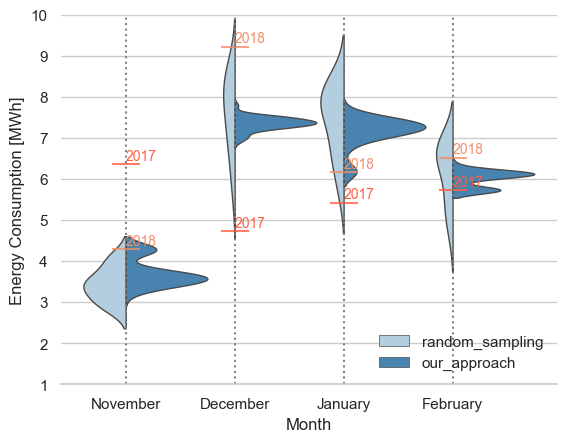

In [69]:
#half violin plots using seaborn graph
#upper values: parameter estimation (in results: simulationdata.values)
#lower values: combinations, last columns
#y1, y2 from Targets (measured values)
import seaborn as sns
sns.set_theme(style="whitegrid")

x1, y1 = ["November", "November"], [1, 10]
x2, y2 = ["December", "December"], [1, 10]
x3, y3 = ["January", "January"], [1, 10]
x4, y4 = ["February", "February"], [1, 10]
plt.plot(x1, y1, x2, y2, x3, y3, x4, y4, color="grey", linestyle = 'dotted')

DataResRanNov = pd.DataFrame({'EnergyConsumption':Results[0] , # Create pandas DataFrame
                     })
DataResRanNov.insert(0, 'Sampling', 'random_sampling')
DataResRanNov.insert(0, 'Month', 'November')
DataResRanNov

DataResRanDec = pd.DataFrame({'EnergyConsumption':Results[1] , # Create pandas DataFrame
                             })
DataResRanDec.insert(0, 'Sampling', 'random_sampling')
DataResRanDec.insert(0, 'Month', 'December')
DataResRanDec

DataResRanJan = pd.DataFrame({'EnergyConsumption':Results[2] , # Create pandas DataFrame
                     })
DataResRanJan.insert(0, 'Sampling', 'random_sampling')
DataResRanJan.insert(0, 'Month', 'January')
DataResRanJan

DataResRanFeb = pd.DataFrame({'EnergyConsumption':Results[3] , # Create pandas DataFrame
                     })
DataResRanFeb.insert(0, 'Sampling', 'random_sampling')
DataResRanFeb.insert(0, 'Month', 'February')
DataResRanFeb

DataResEstNov = pd.DataFrame({'EnergyConsumption':Combinations["Predicted_0"] , # Create pandas DataFrame
                     })
DataResEstNov.insert(0, 'Sampling', 'our_approach')
DataResEstNov.insert(0, 'Month', 'November')
DataResEstNov

DataResEstDec = pd.DataFrame({'EnergyConsumption':Combinations["Predicted_1"] , # Create pandas DataFrame
                     })
DataResEstDec.insert(0, 'Sampling', 'our_approach')
DataResEstDec.insert(0, 'Month', 'December')
DataResEstDec
DataResEstJan = pd.DataFrame({'EnergyConsumption':Combinations["Predicted_2"] , # Create pandas DataFrame
                     })
DataResEstJan.insert(0, 'Sampling', 'our_approach')
DataResEstJan.insert(0, 'Month', 'January')
DataResEstJan
DataResEstFeb = pd.DataFrame({'EnergyConsumption':Combinations["Predicted_3"] , # Create pandas DataFrame
                     })
DataResEstFeb.insert(0, 'Sampling', 'our_approach')
DataResEstFeb.insert(0, 'Month', 'February')
DataResEstFeb

DataRes = [DataResRanNov,DataResRanDec,DataResRanJan, DataResRanFeb, DataResEstNov, DataResEstDec,DataResEstJan, DataResEstFeb ]
DataResArray = pd.concat(DataRes)
DataResArray

ax=sns.violinplot(data=DataResArray, width=1.5, x="Month", y="EnergyConsumption", hue="Sampling",
                split=True, inner=None, linewidth=1,
              palette="Blues")

sns.despine(left=True)
DataTar1=pd.DataFrame({'EnergyConsumption':Targets["value1"] ,'Month':["November", "December", "January", "February"], 'year':["2017", "2017", "2017", "2017"] # Create pandas DataFrame
                     })
DataTar2=pd.DataFrame({'EnergyConsumption':Targets["value2"] ,'Month':["November", "December", "January", "February"], 'year':["2018", "2018", "2018", "2018"]  # Create pandas DataFrame
                     })
sns.regplot(data=DataTar1, x="Month", y="EnergyConsumption", fit_reg=False, marker="_", color="#ff5e44", scatter_kws={'s':400})
sns.regplot(data=DataTar2, x="Month", y="EnergyConsumption", fit_reg=False, marker="_", color='#f28f6b', scatter_kws={'s':400})
# add annotations one by one with a loop
for line in range(0,DataTar1.shape[0]):
     plt.text(DataTar1.Month[line], DataTar1.EnergyConsumption[line]+0.1, DataTar1.year[line], horizontalalignment='left', size='small', color='#ff5e44')
for line in range(0,DataTar2.shape[0]):
    plt.text(DataTar2.Month[line], DataTar2.EnergyConsumption[line]+0.1, DataTar2.year[line], horizontalalignment='left', size='small', color='#f28f6b')

    plt.legend(frameon=False, loc='lower right')


# Set x-axis label
#plt.xlabel('Month')
# Set y-axis label
plt.ylabel('Energy Consumption [MWh]')
plt.ylim(1, 10)
plt.savefig('violin.pdf')
plt.show()
